In [2]:
import pennylane as qml
import pennylane.numpy as np

In [3]:
np.set_printoptions(precision=3)

# FC-TFI model

## References

[1]  K. Fujii, K. Nakajima, [Harnessing disordered quantum dynamics for machine learning](https://arxiv.org/abs/1602.08159v2), Phys. Rev. Applied 8, 024030 (2017)

[2]  K. Fujii, K. Nakajima, [Quantum reservoir computing: a reservoir approach toward quantum machine learning on near-term quantum devices](https://arxiv.org/abs/2011.04890), arXiv:2011.04890

[3] Z. Mlika et al., [User Trajectory Prediction in Mobile Wireless Networks Using Quantum Reservoir Computing](https://arxiv.org/abs/2301.08796), arXiv:2301.08796

## Quantum reservoir

Comparison between conventional (upper) and quantum (lower) reservoir computing approaches [1] for an input signal like a temporal sequence or time series. 

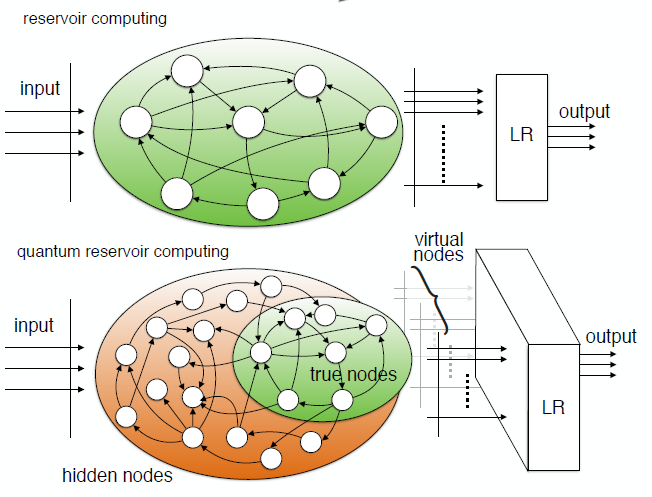

An example of conventional or classical reservoir computing framework is provided by recurrent neural networks where all the weights of the nodes must be learned.

The circles in the QRC represent the basis of the Hilbert space spanned by the qubits. 
The true nodes correspond to a subset of basis of the operator space that are directly monitored by the ensemble measurements. The hidden nodes correspond to the remaining degrees of freedom.
Virtual nodes are constructed to enable learning the readout weights of the output signal.

## FC-TFI Hamiltonian

> The fuly connected transverse field Ising model (interacting spin system) is described by the well-known FC-TFI Hamiltonian:
$$ H = \sum_{ij} J_{ij} X_i X_j + h Z_i$$
where the coupling strength $J_{ij}$ are randomly chosen from any simple statistical distribution (e.g. uniformly in $[-J/2, J/2]$ interval) and a scale factor can be applied to make the coupling dimensionless.

In general, time evolution of a quantum system described by a Hamiltonian $H$ is obtained by

$$ \rho(t + \tau) = e^{-i H \tau} \rho(t) e^{i H \tau}$$ where $\rho$ is the density matrix of the system.

> Moreover, for a Hamiltonian concisting of a sum of distinct terms, the Trotterization method enables to approximate its evolution over a certain number of steps. This is what we will examine herafter. 

### First term - XX operator

> Subcircuit corresponding to $\exp (-i J_{ij} X_i X_j t)$

#### Function definitions

In [1]:
def subcircuit_XX(J, N, time):
    """Creates the subcircuit corresponding to exp(-i J_ij X_i X_j t).

    Args:
        J (list(float): A vector of couplings [J_ij] (upper triangular indices of NxN matrix)
        N (integer): number of qubits
        time (float): The time we evolve the electron wavefunction for 

    """
    k=0
    for i in range(N):
        for j in range(i + 1, N):
            qml.Hadamard(wires=i)
            qml.Hadamard(wires=j)
            qml.CNOT(wires=[i, j])
            qml.RZ(J[k] * time, wires=j)
            qml.CNOT(wires=[i, j])
            qml.Hadamard(wires=i)
            qml.Hadamard(wires=j)
            k+=1

In [14]:
@qml.qnode(dev)
def circuit_xx(J, N, time, init):
    """Circuit for evolving the subcircuit XX of the FC-TFI Hamiltonian.
    
    Args:
        J (list(float): A vector of couplings [J_ij] (upper triangular indices of NxN matrix)
        N (integer): number of qubits
        time (float): The time we evolve the electron wavefunction for.
        init (array(int)): An initial state specified by N bits [x_0, x_1, ..., x_N-1]. Prepare the
            system in this state prior to applying the time evolution circuit.

    Returns: 
        array[float]: Expectation values (or alternatively probabilities for observing different outcomes).
    """
    qml.BasisState(init, wires=range(N))

    subcircuit_XX(J, N, time)

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(N)]
#     return qml.probs(wires=range(N))

#### Example with 2 qubits

In [15]:
n_bits = 2
dev = qml.device("default.qubit", wires=n_bits)

In [16]:
circuit_xx(J=[1/2], N=n_bits, time=1, init=np.array([1,0]))

tensor([-0.878,  0.878], requires_grad=True)

(<Figure size 648x216 with 1 Axes>, <Axes:>)

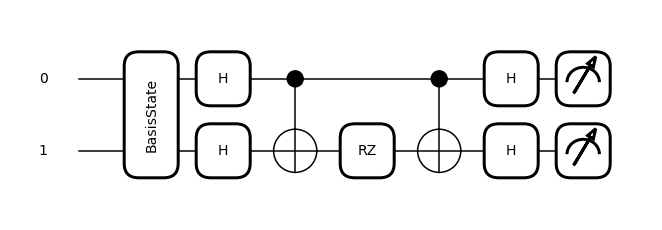

In [17]:
qml.draw_mpl(circuit_xx)(J=[1/2], N=n_bits, time=1, init=np.array([1,0]))

#### Example with 3 qubits

**Simplification**

This XX circuit can be simplified using Pennylane transforms, as successive Hadamard gates cancel out

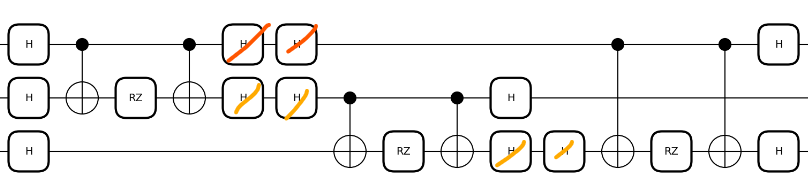

##### Original circuit

In [29]:
n_bits = 3
dev = qml.device("default.qubit", wires=n_bits)

In [30]:
def bare_circuit(J, N, time, init):
    qml.BasisState(init, wires=range(N))

    subcircuit_XX(J, N, time)

    return qml.probs(wires=range(N))

In [31]:
N = n_bits
J = [1/2, 1/2, 1/2]
T = 10
init = np.array([0, 0, 0])

(<Figure size 1900x400 with 1 Axes>, <Axes:>)

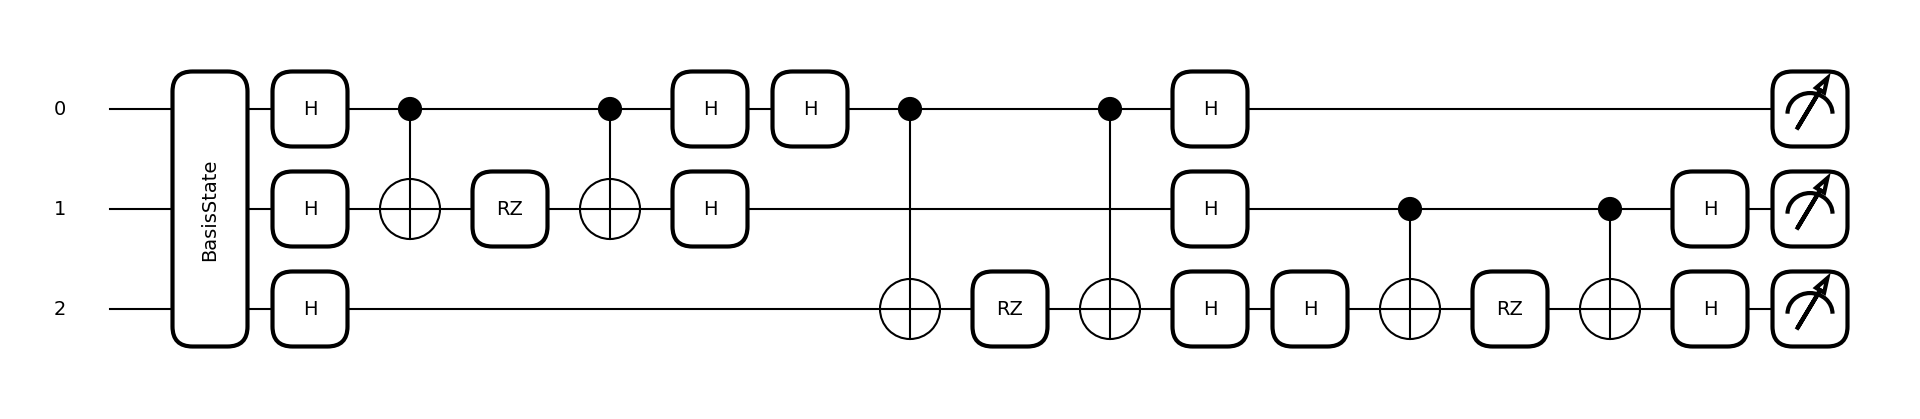

In [32]:
qnode = qml.QNode(bare_circuit, dev)
qml.draw_mpl(qnode)(J, N, T, init)

##### Optimised circuit

(<Figure size 1500x400 with 1 Axes>, <Axes:>)

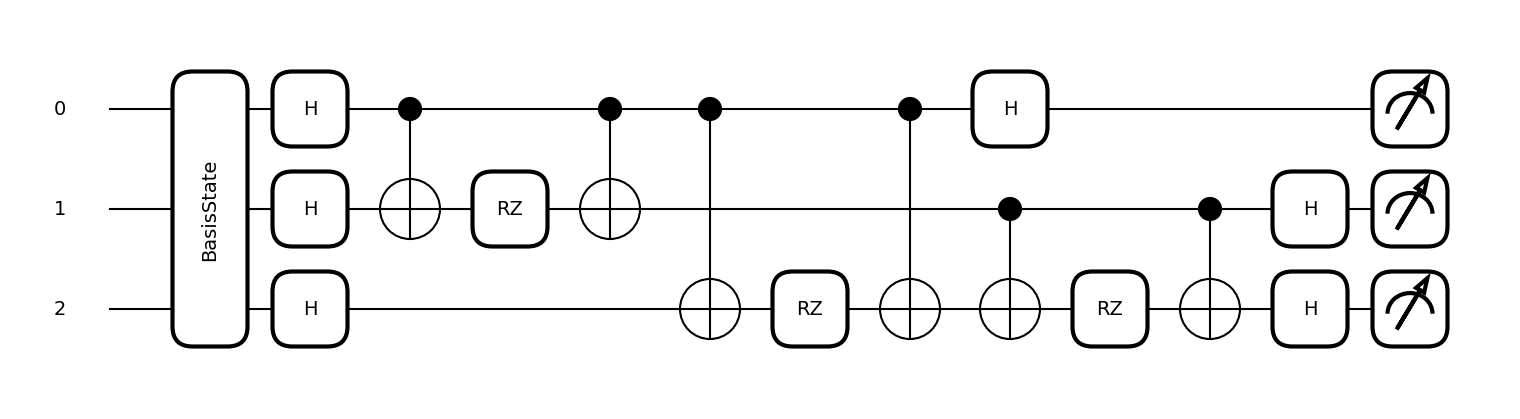

In [33]:
optimized_circuit = qml.transforms.cancel_inverses(bare_circuit)
optimized_qnode_circuit = qml.QNode(optimized_circuit, dev)
qml.draw_mpl(optimized_qnode_circuit)(J, N, T, init)

### Second term - Z operator

> Subcircuit corresponding to $\exp (-i h_i Z_i t)$

In [150]:
def subcircuit_Z(h, N, time):
    """Creates the subcircuit corresponding to exp(-i h_i Z_i t).

    Args:
        h (float): The strength of the field, assumed to point in the z direction
        N (integer): number of qubits
        time (float): The time we evolve the electron wavefunction for 

    """
    for i in range(N):
        qml.RZ(h * time, wires=i)

In [151]:
@qml.qnode(dev)
def circuit_z(h, N, time, init):
    """Circuit for evolving the subcircuit Z of the FC-TFI Hamiltonian.
    
    Args:
        h (float): The strength of the field, assumed to point in the z direction
        N (integer): number of qubits
        time (float): The time we evolve the electron wavefunction for.
        init (array(int)): An initial state specified by N bits [x_0, x_1, ..., x_N-1]. Prepare the
            system in this state prior to applying the time evolution circuit.

    Returns: 
        array[float]: Expectation values (or alternatively probabilities for observing different outcomes).
    """
    qml.BasisState(init, wires=range(N))

    subcircuit_Z(h, N, time)

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(N)]
#     return qml.probs(wires=range(N))

In [152]:
n_bits = 2
dev = qml.device("default.qubit", wires=n_bits)

In [153]:
circuit_z(h=.1, N=n_bits, time=1, init=np.array([1,1]))

tensor([-1., -1.], requires_grad=True)

(<Figure size 500x300 with 1 Axes>, <Axes:>)

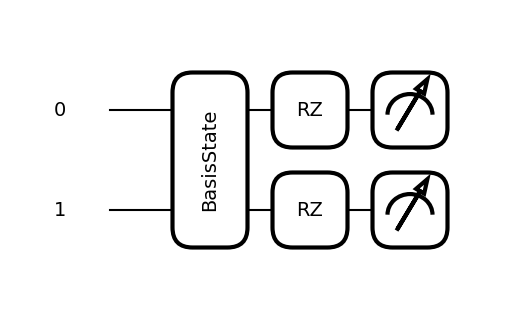

In [154]:
qml.draw_mpl(circuit_z)(h=.1, N=n_bits, time=1, init=np.array([1,0]))

### Circuit of FC-TFI Hamiltonian

> Combining Subcircuit XX and Z

In [155]:
def fc_tfi(h, J, N, time, init, n):
    """Circuit for evolving the FC-TFI Hamiltonian.
    
    Args:
        h (float): The strength of the field, assumed to point in the z direction.
        J (list(float): A vector of couplings [J_ij] (upper triangular indices of NxN matrix)
        N (integer): number of qubits
        time (float): The time we evolve the electron wavefunction for.
        init (array(int)): An initial state specified by N bits [x_0, x_1, ..., x_N-1]. Prepare the
            system in this state prior to applying the time evolution circuit.

    Returns: 
        array[float]: Expectation values (or alternatively probabilities for observing different outcomes).
    """
    qml.BasisState(init, wires=range(N))

    for k in range(1, n+1):
        subcircuit_Z(h, N, time)
        subcircuit_XX(J, N, time)

#     return [qml.expval(qml.PauliZ(wires=i)) for i in range(N)]
#     return qml.probs(wires=range(N))
    return qml.state()

## Time evolution of Hamiltonian

> Trotterization with Pennylane methods

### FC-TFI Hamiltonian

> Using **qml.Hamiltonian** https://docs.pennylane.ai/en/stable/code/api/pennylane.Hamiltonian.html

In [201]:
def fc_tfi_hamiltonian(h, J, N):
    """Creates the FC-TFI Hamiltonian.

    Args:
        h (float): The strength of the field, assumed to point in the z direction.
        J (list(float): A vector of couplings [J_ij] (upper triangular indices of NxN matrix)
        N (integer): number of qubits

    Returns:
        qml.Hamiltonian: The Hamiltonian of the system.
    """

    coeffs = [h * x for x in np.ones(N)] + [x for x in J]

    obs_z = [qml.PauliZ(i) for i in range(N)]
    obs_xx = []
    for i in range(N):
        for j in range(i + 1, N):
            obs_xx.append(qml.PauliX(i) @ qml.PauliX(j))
    obs = obs_z + obs_xx

    return qml.Hamiltonian(coeffs, obs)

In [202]:
# Example:
fc_tfi_hamiltonian(h=1/2, J=[1, -1,-1,1/2,1/2,1/2], N=4)

  (0.5) [Z0]
+ (0.5) [Z1]
+ (0.5) [Z2]
+ (0.5) [Z3]
+ (-1) [X0 X2]
+ (-1) [X0 X3]
+ (0.5) [X1 X2]
+ (0.5) [X1 X3]
+ (0.5) [X2 X3]
+ (1) [X0 X1]


### Approximate time evolution

> Using **qml.ApproxTimeEvolution** https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html

NB: The gate circuit above should be repeated n times to approximate the time evolution

Here we prefer using the pennylane function but it is possible to verify that both methods yield the same results

Example - verified using Quirk - https://algassert.com/quirk

n=2 and n_bits=2
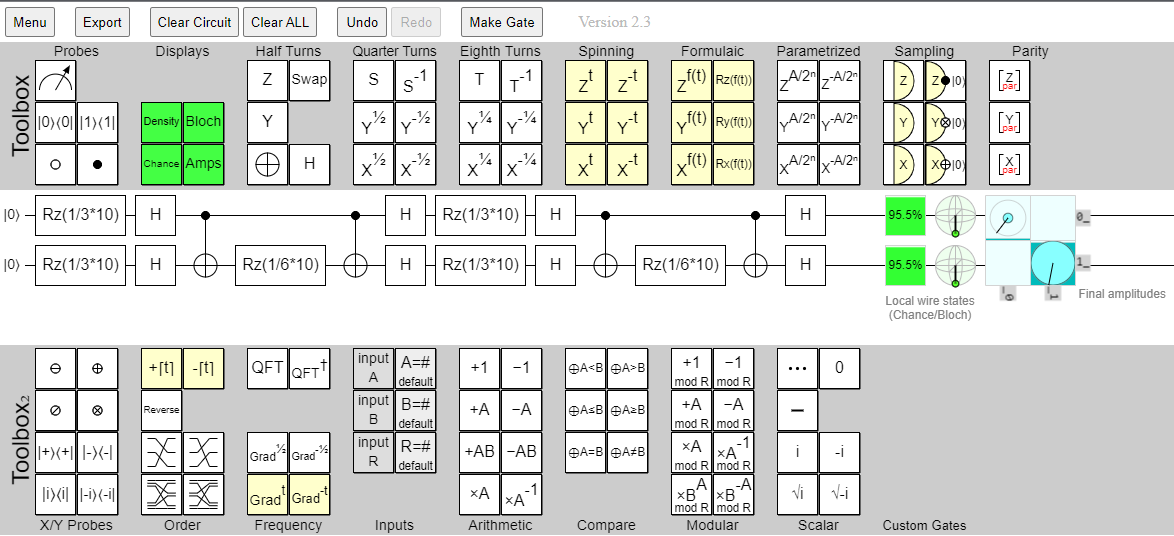

State:
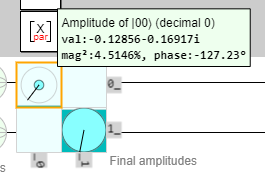
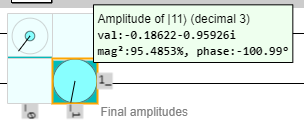

Execution of Trotterization:
result: [-0.129-0.169j  0.   +0.j     0.   +0.j    -0.186-0.959j]

In [200]:
@qml.qnode(dev)
def fc_tfi_evol(h, J, N, time, init, n):
    """Circuit for evolving the state of three nearby electrons with an arbitrary coupling.
    
    Args:
        h (float): The strength of the field, assumed to point in the z direction.
        J (list(float): A vector of couplings [J_ij] (upper triangular indices of NxN matrix)
        N (integer): number of qubits
        time (float): The time we evolve the electron wavefunction for.
        init (array(int)): An initial state specified by N bits [x_0, x_1, ..., x_N-1]. Prepare the
            system in this state prior to applying the time evolution circuit.
        n (int): The number of steps in our Trotterization.

    Returns: 
        array[float]: Expectation values (or alternatively probabilities for observing different outcomes).
    """

    qml.BasisState(init, wires=range(N))

    hamiltonian = fc_tfi_hamiltonian(h, J, N)
    qml.ApproxTimeEvolution(hamiltonian, time, n)
    
#     return [qml.expval(qml.PauliZ(wires=i)) for i in range(N)]
#     return qml.probs(wires=range(N))
    return qml.state()

### Experiment with 2 qubits

In [203]:
n_bits = 2
dev = qml.device("default.qubit", wires=n_bits)

#### (Optimized) gate circuit

In [204]:
N = n_bits
h = 1/3
J = [1/6]
T = 10
init = np.array([1, 1])
n = 2

(<Figure size 1600x300 with 1 Axes>, <Axes:>)

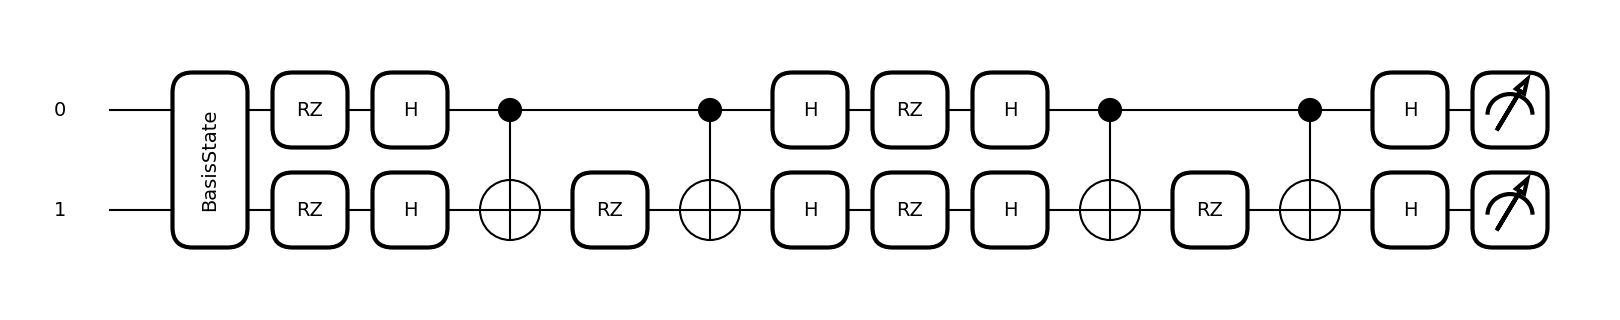

In [205]:
optimized_circuit = qml.transforms.cancel_inverses(fc_tfi)
optimized_qnode_circuit = qml.QNode(optimized_circuit, dev)
qml.draw_mpl(optimized_qnode_circuit)(h, J, N, T, init, n)

In [206]:
optimized_qnode_circuit(h, J, N, T, init, n)

tensor([ 0.186-0.959j,  0.   +0.j   ,  0.   +0.j   , -0.129+0.169j], requires_grad=True)

In [207]:
qml.QNode(fc_tfi, dev)(h, J, N, T, init, n)

tensor([ 0.186-0.959j,  0.   +0.j   ,  0.   +0.j   , -0.129+0.169j], requires_grad=True)

#### Trotterization

In [208]:
fc_tfi_hamiltonian(h, J, N)

  (0.3333333333333333) [Z0]
+ (0.3333333333333333) [Z1]
+ (0.16666666666666666) [X0 X1]


In [209]:
for k in range(1,n+1):
    print(qml.QNode(fc_tfi_evol, dev)(h, J, N, T, init, n=k))

[ 0.372-0.923j  0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
  0.   +0.j    -0.089-0.036j  0.   +0.j   ]
[ 0.186-0.959j  0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
  0.   +0.j    -0.129+0.169j  0.   +0.j   ]


### Experiment with 3 qubits

In [210]:
n_bits = 3
dev = qml.device("default.qubit", wires=n_bits)

In [217]:
N = n_bits
h = 1/3
J = [1/6, 1/6, 1/6]
T = 10
init = np.array([0, 0, 0])
n = 2

(<Figure size 2800x400 with 1 Axes>, <Axes:>)

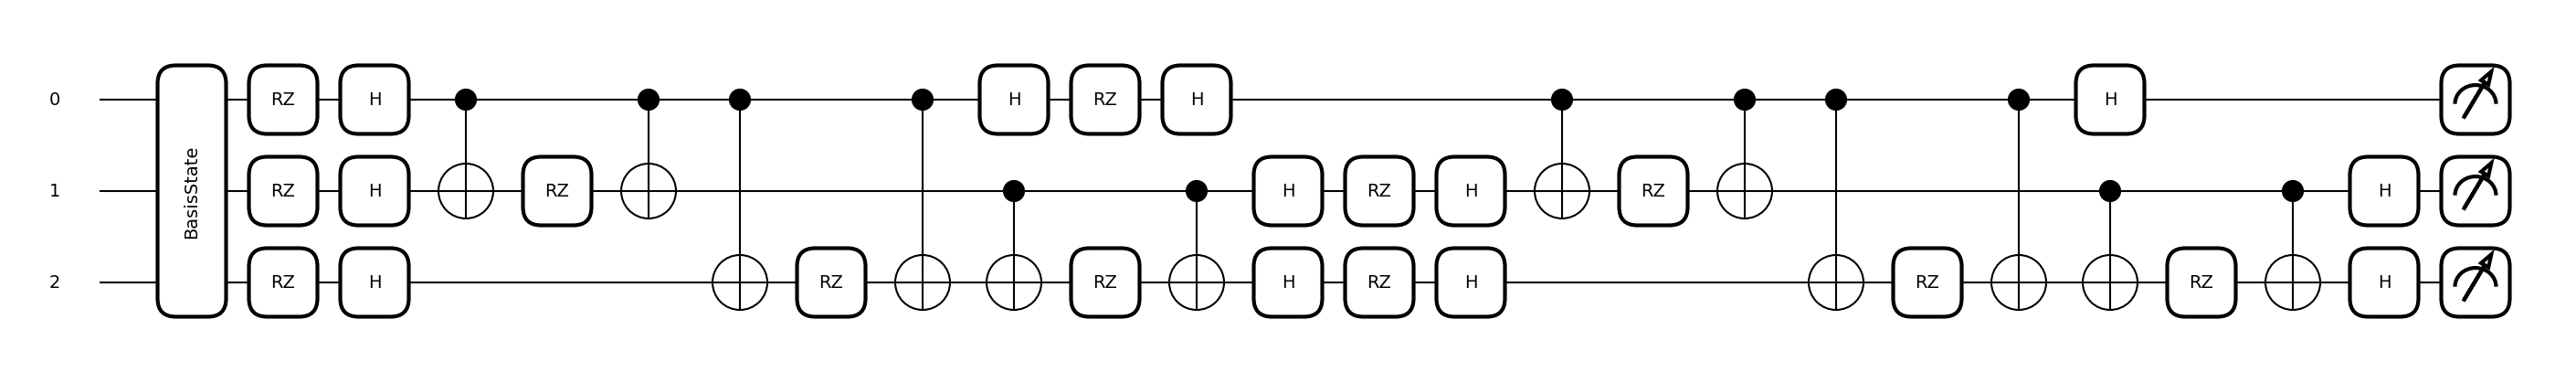

In [218]:
optimized_circuit = qml.transforms.cancel_inverses(fc_tfi)
optimized_qnode_circuit = qml.QNode(optimized_circuit, dev)
qml.draw_mpl(optimized_qnode_circuit)(h, J, N, T, init, n)

In [219]:
optimized_qnode_circuit(h, J, N, T, init, n)

tensor([-0.285-9.587e-01j,  0.   +0.000e+00j,  0.   +0.000e+00j,
         0.001-4.027e-04j,  0.   +0.000e+00j,  0.001-4.027e-04j,
         0.001-4.027e-04j,  0.   +0.000e+00j], requires_grad=True)

In [220]:
qml.QNode(fc_tfi, dev)(h, J, N, T, init, n)

tensor([-0.285-9.587e-01j,  0.   +0.000e+00j,  0.   +0.000e+00j,
         0.001-4.027e-04j,  0.   +0.000e+00j,  0.001-4.027e-04j,
         0.001-4.027e-04j,  0.   +0.000e+00j], requires_grad=True)

In [221]:
fc_tfi_hamiltonian(h, J, N)

  (0.3333333333333333) [Z0]
+ (0.3333333333333333) [Z1]
+ (0.3333333333333333) [Z2]
+ (0.16666666666666666) [X0 X1]
+ (0.16666666666666666) [X0 X2]
+ (0.16666666666666666) [X1 X2]


In [222]:
for k in range(1,n+1):
    print(qml.QNode(fc_tfi_evol, dev)(h, J, N, T, init, n=k))

[-0.536-0.828j  0.   +0.j     0.   +0.j    -0.075+0.059j  0.   +0.j
 -0.075+0.059j -0.075+0.059j  0.   +0.j   ]
[-0.285-9.587e-01j  0.   +0.000e+00j  0.   +0.000e+00j  0.001-4.027e-04j
  0.   +0.000e+00j  0.001-4.027e-04j  0.001-4.027e-04j  0.   +0.000e+00j]


# Application to temporal sequences

Ref: [1], [2] and [3]

## Algorithm for the QR dynamics

* The nodes of the quantum reservoir network are defined from the orthogonal basis of quantum states. Hence, for N qubits, we
have $2^N$ basis states for a pure quantum state.

* To exploit quantum dynamics for information processing, we need to introduce an input and the signals of the quantum system

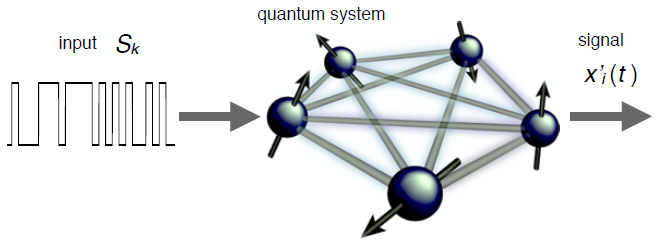

* Let $\{ s_k \}_{k=1}^M$ be an input sequence, where $s_k$ can be a binary ($\in \{0, 1\}$) or a continuous variable ($\in [0,1]$).

* The learning task consists in finding, using the quantum system (i.e. the reservoir), a nonlinear function $y_k = f(\{ s_l \}_{l=1}^k)$ such that the mean squared error (MSE) between $y_k$ and a target output $\bar{y}_k$ be minimized.

To do so, the following algorithm is implemented:

- At each time $t=k \tau$, the input signal $s_k$ is injected into the 1st qubit, by replacing it with the state 
$\rho_{s_k} = \vert \psi_{s_k} \rangle \langle \psi_{s_k} \vert$, 
where $\vert \psi_{s_k} \rangle := \sqrt{1-s_k} \vert 0 \rangle + \sqrt{s_k} \vert 1 \rangle$.

- After the injection, the system evolves under the Hamiltonian $H$ for a time interval $\tau$.

- The signal, which is exploited for the learning process, is defined as an average value of PauliZ operator acting on each qubit.

    - The directly observed signals $\{x_i(t)\}_{i=1}^N$ are the **true nodes**.

    - The remaining nodes of $\mathbf{x}(t)$ are the **hidden nodes**; they are not employed for the learning task - by contrast with classical reservoir computing, where all hidden nodes are used.

    - In addition to the true nodes, a procedure is applied to construct **virtual nodes** to improve the learning performance (see hereafter)

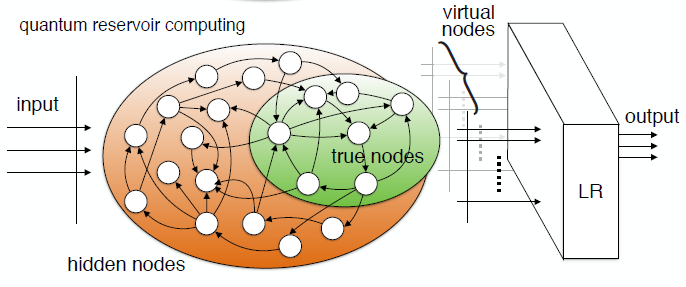

- For the learning task, a possible choice is to add a bias term and apply a rescaling factor for convenience. The true nodes become: $x'_i(t) := \text{Tr} [(I + Z_i)/2 \rho(t)] = (x_i(t) + 1)/2$

- Training process (i.e. learning the readout weights from the observed signals):
    
    - Signals are sampled from the QR not only at the time $k \tau$, but also at each of the subdivided $V$ timesteps during the unitary evolution, resulting in $NV$ virtual nodes in total at each timestep $k$. These are the aforementioned **virtual nodes**. 
    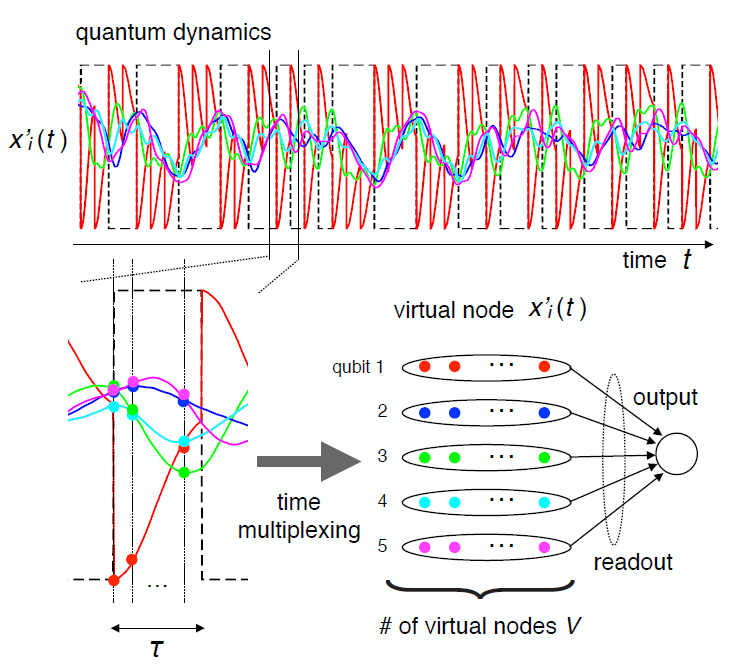
    
    - Assuming learning is performed by using $L$ timesteps. 
    - Let $\{x'_{ki} \}$ ($1 <= i <= NV$ and $1 <= k <= L$) be the states of the virtual nodes in the learning phase. 
    - Let $\{\bar{y}_{k=1}^L \}$ be the target sequence for the learning. 
    
    The learning task amounts to solving the following equation: $$\mathbf{\bar{y}} = \mathbf{X w}$$ minimizing the MSE:
    $$\frac{1}{L} \sum_{k=1}^{L} (y_k - \bar{y}_k)^2$$
    which can be performed using the Moore-Penrose pseudo-inverse (cf. https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) $\mathbf{X}^+$, that is: $$\mathbf{w^{\text{LR}}} := \mathbf{X}^+ \mathbf{\bar{y}}$$
    Using $\mathbf{w^{\text{LR}}}$, we obtain the output from the QR: $$\bar{y}_k = \sum_{i=0}^{NV} w_i^{\text{LR}} x'_{ki}$$ 



## Use cases

Goal: reproducing experiments in [1] and [3]

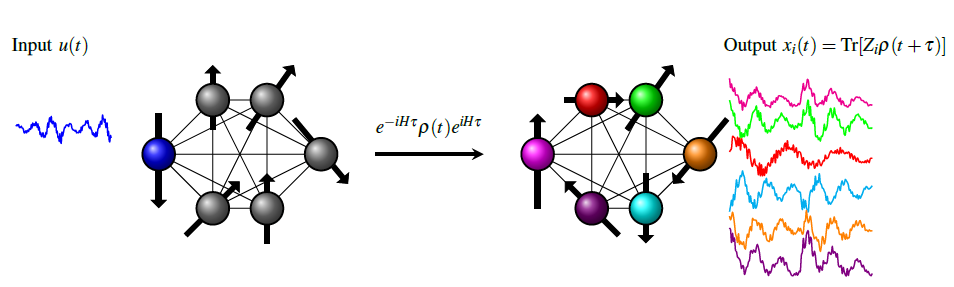

### A Timer task

Ref: [1]

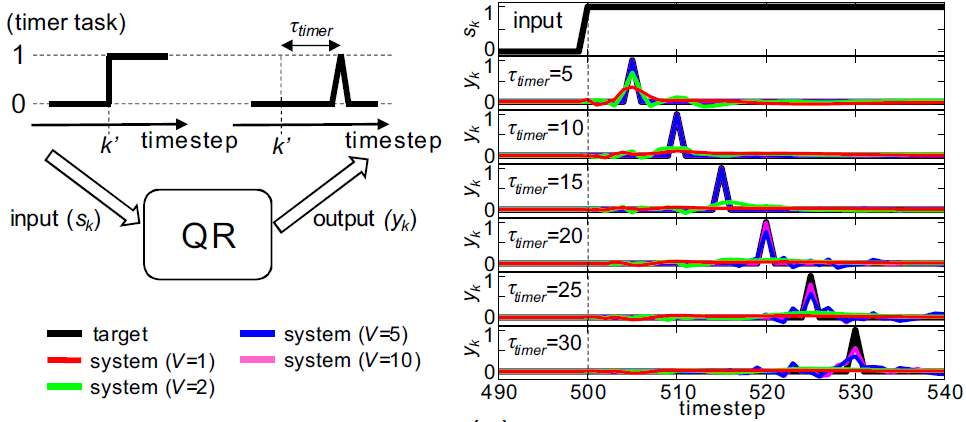

> The input is flipped from 0 to 1 at certain timestep $k'$ as a cue, and the system should output 1 if $\tau_{\text{timer}}$ timesteps have passed from the cue, otherwise it should output 0 (see left diagram).


#### Architecture and settings

In the article [1], a 6-qubit QR system is prepared. 

> starting from different initial conditions, 10 trials of numerical experiments were run for each $\tau_{\text{timer}}$ setting

> $k'$ is set to 500 throughout the numerical experiments

> The plots overlay the averaged system performance over 10 trials for V = 1, 2, 5, and 10 with the target outputs

#### Implementation with pennylane

[not enough time to complete this task!] - TO BE CONTINUED

### NARMA task

Ref: [1]

> Emulation of nonlinear dynamical systems, called *nonlinear auto-regressive moving average* (NARMA) systems, which is a standard benchmarktask in the context of recurrent neural network learning.

> example: the following second-order nonlinear dynamical system: $$y_{k+1}=0.4 y_k + 0.4 y_k y_{k-1} + 0.6 s_k^3 + 0.1$$

#### Implementation with pennylane

[not enough time to complete this task!] - TO BE CONTINUED